<!-- PS-S4.E11 | AutoEDA - OpenAI - AutoGluon Baseline -->

<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: left; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
    Predicting Depression with LLM-Assisted EDA and AutoML<br>
</div>

<div style="text-align: center;">
  <img src="https://i.imgur.com/EhXAhl1.jpg" alt="Centered Image" style="max-width: 60%; height: auto;">
</div>

Photo de <a href="https://unsplash.com/fr/@dmey503?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Dan Meyers</a> sur <a href="https://unsplash.com/fr/photos/nabandonnez-pas-vous-netes-pas-seul-vous-comptez-sur-la-signalisation-sur-la-cloture-metallique-hluOJZjLVXc?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Challenge Overview</div>

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Competition</div>

- **Objective:** Participants analyze a synthetic dataset based on a mental health survey to identify factors linked to depression, predicting whether individuals are likely to experience depression.
- **Evaluation:** Submissions are scored by accuracy, with predictions required for each row in the test set as either 0 (no depression) or 1 (depression).

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Notebook aim</div>

- In this notebook, I am experimenting with automated EDA tools to see if I can get quick insights into the datasets and train a baseline model.
- I am using Sweetviz and ydata_profiling to generate quick data visualizations and insights, and LangChain and GPT to generate quick data reports and generate python code.

In [1]:
!pip install ray==2.10.0 autogluon.tabular  > /dev/null 2>&1
!pip install optuna-integration[sklearn] > /dev/null 2>&1
!pip install langchain-core > /dev/null 2>&1
!pip install langchain-openai  > /dev/null 2>&1
!pip install sweetviz > /dev/null 2>&1
!pip install numba==0.58.1 visions==0.7.5 pandas==1.5.3 ydata-profiling==4.7.0 > /dev/null 2>&1

In [2]:
# General Purpose Libraries
import logging
import tempfile
import json

# Data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

# Auto EDA
import sweetviz as sv
from ydata_profiling import ProfileReport

# LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import Markdown, display, IFrame

# Feature engineering
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from featuretools import dfs, EntitySet

# Auto ML
from autogluon.tabular import TabularPredictor

# supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
TIME_LIMIT = 3600

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("openai_key")

In [5]:
# Define the LLM model using LangChain
model = ChatOpenAI(
    model='o1-mini',
    temperature=1,
    api_key=OPENAI_API_KEY
)

In [6]:
# Define the prompt template for LangChain
template_eda = """Provide an analysis of the following EDA summary:
{context}

Key insights and observations:
"""

In [7]:
# Function to classify columns into continuous and categorical
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Function to perform basic visualizations for continuous and categorical features
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)
    
    # Plotting continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plotting categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Count plot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Function to compare train and test datasets
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)
    
    # Compare continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Compare categorical columns
    for col in categorical_cols:
        if col in test.columns:  # Ensure the column exists in the test dataset
            plt.figure(figsize=(10, 4))
            train_counts = train[col].value_counts(normalize=True)
            test_counts = test[col].value_counts(normalize=True)
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()
            
# Function to create key statistics for a dataset
def eda_summary(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types
    summary['data_types'] = df.dtypes.to_dict()
    
    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    
    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .to_dict(orient='index')
    )
    
    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )
    
    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns
    }
    
    # Correlations
    try:
        summary['correlations'] = df.corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."
    
    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA</div>

In [8]:
# Load the dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

In [9]:
train_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [10]:
test_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [11]:
sample_submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [12]:
train_data.shape

(140700, 20)

In [13]:
test_data.shape

(93800, 19)

In [14]:
train_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [15]:
test_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
count,93800.000000,93800.000000,18767.000000,75022.000000,18766.000000,18767.000000,75026.00000,93800.000000,93800.000000
mean,187599.500000,40.321685,3.158576,3.011797,7.674016,2.939522,2.96092,6.247335,2.978763
std,27077.871962,12.393480,1.386666,1.403563,1.465056,1.374242,1.41071,3.858191,1.414604
min,140700.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.00000,0.000000,1.000000
25%,164149.750000,29.000000,2.000000,2.000000,6.330000,2.000000,2.00000,3.000000,2.000000
50%,187599.500000,42.000000,3.000000,3.000000,7.800000,3.000000,3.00000,6.000000,3.000000
75%,211049.250000,51.000000,4.000000,4.000000,8.940000,4.000000,4.00000,10.000000,4.000000
max,234499.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.00000,12.000000,5.000000


## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA report with Sweetviz</div>

In [16]:
# Generate the report with Sweetviz
target_variable = "Depression"
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat=target_variable)
report_path = 'Comparative_EDA_Report.html'
report.show_html(filepath=report_path, open_browser=False)

# Display the report inline in Kaggle
IFrame(src=report_path, width=1000, height=600)

                                             |          | [  0%]   00:00 -> (? left)

Report Comparative_EDA_Report.html was generated.


## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA report with YData Profiling</div>

In [17]:
# Generate Pandas Profiling report for the training data
profile_train = ProfileReport(train_data, title="Train Data Profile Report", explorative=True)
profile_train_path = 'Train_Data_Profile_Report.html'
profile_train.to_file(profile_train_path)

# Display the training report inline in Kaggle
display(IFrame(src=profile_train_path, width=1000, height=600))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# Generate Pandas Profiling report for the test data
profile_test = ProfileReport(test_data, title="Test Data Profile Report", explorative=True)
profile_test_path = 'Test_Data_Profile_Report.html'
profile_test.to_file(profile_test_path)

# Display the test report inline in Kaggle
display(IFrame(src=profile_test_path, width=1000, height=600))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Automated EDA with Langchain</div>

In [19]:
summary = eda_summary(train_data)
summary_json = json.dumps(summary, indent=4, default=str)

In [20]:
# Define the prompt template for LangChain
template = """Provide an analysis of the following EDA summary, The aim of this dataset and EDA is to understand how several variables influence depression.
Ultimately the aim is to build a classification model to predict depression:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json)

# Print the result
display(Markdown(result))

### **Exploratory Data Analysis (EDA) Summary Analysis**

The provided EDA summary offers a comprehensive overview of a dataset comprising 140,700 records and 20 variables aimed at understanding the factors influencing depression. The ultimate goal is to develop a classification model to predict depression outcomes. Below, we delve into key insights and observations derived from the EDA, highlighting crucial aspects that will inform subsequent modeling efforts.

---

#### **1. Dataset Overview**

- **Size & Structure:**
  - **Rows:** 140,700
  - **Columns:** 20
  - **Missing Values:** 430,876 (15.31%)

- **Data Types:**
  - **Numerical:** Includes variables like Age, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, Work/Study Hours, Financial Stress, and Depression.
  - **Categorical:** Variables such as Name, Gender, City, Employment Status (Working Professional or Student), Profession, Sleep Duration, Dietary Habits, Degree, Suicidal Thoughts, and Family History of Mental Illness.

**Implication:** The substantial size of the dataset is advantageous for building robust models. However, the presence of significant missing values in several key variables necessitates careful handling to ensure data quality and model performance.

---

#### **2. Missing Data Analysis**

- **High Imputation Necessity:**
  - **Academic Pressure, CGPA, Study Satisfaction:** ~80% missing
  - **Profession:** ~26% missing
  - **Work Pressure & Job Satisfaction:** ~20% missing

- **Minimal Missingness:**
  - Other variables, including critical predictors like Gender, Age, City, and Depression, have negligible missing values.

**Implications & Recommendations:**

- **Data Imputation Strategies:**
  - **Multiple Imputation or Advanced Techniques:** Given the high missingness in variables like Academic Pressure and CGPA, imputing these accurately is challenging. Consider leveraging model-based imputation methods or incorporating supplemental data sources if available.
  
  - **Feature Engineering:** Assess whether these variables are essential or if proxies can be constructed. High missingness may also indicate inherent issues with data collection, warranting a reevaluation of their inclusion.

- **Potential Exclusion:**
  - If imputation is not viable and missingness is not random, consider excluding highly missing variables or investigating the pattern to understand underlying reasons.

---

#### **3. Categorical Variable Insights**

- **Diversity in Categories:**
  - **Name:** 422 unique entries, likely unique identifiers, which may not contribute meaningfully to the model and can be excluded.
  
  - **City:** 98 unique cities, indicating geographic diversity. Could be processed into regional groupings if relevant.
  
  - **Degree & Profession:** High uniqueness (115 and 64 respectively). May require encoding strategies that capture the essence without introducing excessive dimensionality (e.g., grouping similar professions).

- **Binary Variables:**
  - **Gender, Employment Status, Suicidal Thoughts, Family History of Mental Illness:** With only two unique categories, these variables are straightforward to encode (e.g., binary encoding) and likely significant predictors.

**Implications:**

- **Encoding Strategies:** Use appropriate encoding (e.g., One-Hot Encoding, Binary Encoding) while managing high-cardinality categorical variables to prevent the curse of dimensionality.

- **Feature Selection/Engineering:** For high-unique categorical variables, consider dimensionality reduction techniques or feature engineering to extract meaningful patterns.

---

#### **4. Numerical Variable Distribution**

- **Skewness & Kurtosis:**
  - **Depression:** 
    - **Skewness:** 1.65 (positively skewed)
    - **Kurtosis:** 0.73 (lightly leptokurtic)
  
  - **Age:** Slight negative skewness (-0.22) and low kurtosis (-1.15)
  
  - **Academic Pressure, CGPA, Study Satisfaction, Job Satisfaction, etc.:** Generally low skewness with light kurtosis, indicating relatively normal distributions except for 'Depression'.

**Implications:**

- **Target Variable (Depression):**
  - The positive skewness suggests a majority of instances with lower depression scores and fewer with high scores. This imbalance needs addressing, possibly through techniques like oversampling minority classes (e.g., SMOTE) or adjusting class weights during model training.

- **Normalization/Standardization:**
  - Most numerical variables appear to be moderately distributed, but normalization or standardization may still be beneficial, especially for algorithms sensitive to feature scaling.

---

#### **5. Correlation Analysis**

- **Noteworthy Correlations with Depression:**
  - **Age:** Strong negative correlation (-0.56)
  - **Academic Pressure:** Moderate positive correlation (0.475)
  - **Work Pressure:** Positive correlation (0.216)
  - **Financial Stress:** Positive correlation (0.227)
  - **Other Notable Relationships:**
    - **Age** inversely correlates with Work/Study Hours (-0.118) and Financial Stress (-0.084).
    - **Academic Pressure** shows inverse correlations with CGPA (-0.025) and Study Satisfaction (-0.112).

- **Anomalies & Data Quality Issues:**
  - **Job Satisfaction & Study Satisfaction:** Exhibit perfect negative and positive correlations (-1.0 and +1.0 respectively) with Academic Pressure and Depression, which is highly unusual and may indicate data entry errors or encoding issues.

**Implications & Recommendations:**

- **Data Integrity Checks:** The perfect correlations (e.g., -1.0) between certain variables suggest potential data quality problems. Investigate these variables to ensure accurate data collection and encoding.

- **Feature Selection:**
  - Variables with high correlation to depression (both positive and negative) are prime candidates for inclusion in the predictive model.
  
  - Avoid multicollinearity by assessing correlations among predictors and possibly employing dimensionality reduction techniques like PCA if necessary.

- **Causality Considerations:** While correlations highlight associations, they do not imply causation. Further analysis or domain expertise is required to interpret these relationships meaningfully.

---

#### **6. Outlier Analysis**

- **Depression Variable:**
  - **Outliers:** 25,567 instances (18.17%)
  
- **Other Variables:**
  - No outliers detected.

**Implications:**

- **Handling Outliers:**
  - For the 'Depression' variable, the presence of outliers may influence model performance, especially for algorithms sensitive to extreme values (e.g., logistic regression). Consider:
    - **Winsorization:** Capping extreme values.
    - **Robust Scaling:** Utilizing scaling methods less sensitive to outliers.
    - **Separate Modeling:** Treating outliers as a separate class if they represent a meaningful subset.

- **Data Quality for Other Variables:**
  - The absence of outliers in other variables suggests good data quality or possibly conservative outlier detection methods. Ensure that outlier detection criteria are appropriately set to capture genuine anomalies.

---

#### **7. Final Considerations for Model Building**

- **Target Variable Distribution:**
  - The skewed distribution of the 'Depression' variable indicates class imbalance, which could bias the model towards predicting the majority class. Implement balancing techniques such as:
    - **Resampling Methods:** Oversampling the minority class or undersampling the majority class.
    - **Algorithmic Approaches:** Using algorithms that inherently handle imbalanced data or adjusting class weights.

- **Feature Engineering:**
  - Leverage existing variables to create composite features that may better capture the underlying factors influencing depression.

- **Handling Missing Data:**
  - Given the high percentage of missing values in key predictors, prioritize robust imputation strategies or reconsider the inclusion of certain variables based on the feasibility of accurate imputation.

- **Model Selection:**
  - Opt for classification algorithms that can handle imbalanced datasets and high-dimensional data, such as Random Forests, Gradient Boosting Machines (e.g., XGBoost), or ensemble methods.

- **Evaluation Metrics:**
  - Given potential class imbalance, rely on metrics beyond accuracy, such as Precision, Recall, F1-Score, ROC-AUC, and confusion matrices to assess model performance effectively.

---

### **Conclusion**

The EDA highlights several critical aspects pivotal for predicting depression:

- **Significant Predictors:** Age, Academic Pressure, Work Pressure, and Financial Stress show meaningful correlations with depression levels.

- **Data Quality Concerns:** Highly missing variables and perfect correlations warrant thorough data cleaning and validation to ensure model reliability.

- **Class Imbalance & Outliers:** Addressing the skewed distribution of the target variable and handling outliers appropriately will be essential for developing an effective classification model.

By addressing these insights, the subsequent modeling phase can be strategically aligned to build a robust and accurate depression prediction model.

- **Note that not all advice for LLMs will be beneficial to follow. Some guidance may be outdated. A better approach could be to combine this with a RAG-LLM that uses the latest resources (such as books and research papers).**
- **For example, GPT outputs often recommend using SMOTE for imbalanced data. However, the current consensus is that this approach is not actually useful.**

In [21]:
# Define the prompt template for LangChain
template_features = """Provide an analysis of the following EDA summary and offer advice on feature engineering to improve predictions of depression:
{context}

Feature Engineering Recommendations for tree-based models:
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke(summary_json)
display(Markdown(result))

Analyzing the provided Exploratory Data Analysis (EDA) summary reveals several insights and opportunities for feature engineering to enhance the predictive performance of tree-based models for depression prediction. Below is a comprehensive analysis followed by tailored feature engineering recommendations.

## **EDA Analysis**

### **1. Data Overview**

- **Dataset Size:**  
  - **Rows:** 140,700  
  - **Columns:** 20  

- **Missing Values:**  
  - **Total Missing:** 430,876  
  - **Percentage Missing:** 15.31%  

### **2. Data Types and Features**

- **Numerical Features:**  
  - Age, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, Work/Study Hours, Financial Stress, Depression

- **Categorical Features:**  
  - ID, Name, Gender, City, Working Professional or Student, Profession, Sleep Duration, Dietary Habits, Degree, Suicidal Thoughts, Family History of Mental Illness

### **3. Missing Data Patterns**

- **High Missingness (>80%):**  
  - Academic Pressure, CGPA, Study Satisfaction

- **Moderate Missingness (~20%):**  
  - Profession (26%), Work Pressure (~20%), Job Satisfaction (~20%)

- **Low Missingness (<1%):**  
  - Dietary Habits, Degree, Financial Stress

- **No Missing Values:**  
  - ID, Name, Gender, Age, City, Working Professional or Student, Sleep Duration, Suicidal Thoughts, Family History of Mental Illness, Work/Study Hours, Depression

### **4. Categorical Feature Insights**

- **High Cardinality:**  
  - Name (422 unique), City (98 unique), Degree (115 unique), Profession (64 unique)

- **Binary/Categorical:**  
  - Gender (2), Working Professional or Student (2), Suicidal Thoughts (2), Family History of Mental Illness (2)

### **5. Numerical Feature Insights**

- **Depression:**  
  - **Skewness:** 1.65 (positive skew)  
  - **Kurtosis:** 0.725

- **Other Features:**  
  - Generally low skewness and negative kurtosis, indicating a platykurtic distribution (light tails)

### **6. Correlation Analysis**

- **Strong Negative Correlation:**  
  - **Age and Depression:** -0.565

- **Strong Positive Correlations:**  
  - **Academic Pressure and Depression:** 0.475  
  - **Financial Stress and Depression:** 0.227  
  - **Work Pressure and Depression:** 0.217  
  - **Job Satisfaction and Depression:** -0.169  

- **Low or Negligible Correlations:**  
  - Most other feature correlations with Depression are weak.

### **7. Outlier Summary**

- **Depression:**  
  - **Outliers:** 25,567 (18.17%)

- **Other Features:**  
  - No significant outliers detected.

## **Feature Engineering Recommendations for Tree-Based Models**

Tree-based models (e.g., Decision Trees, Random Forests, Gradient Boosting Machines) are versatile and can handle various data types effectively. However, thoughtful feature engineering can significantly enhance model performance. Below are targeted recommendations based on the EDA analysis:

### **1. Handling Missing Values**

- **High Missingness Features:**  
  - **Academic Pressure, CGPA, Study Satisfaction (~80% missing):**  
    - **Option 1:** If the missingness is not random and could convey information (e.g., students not reporting due to low engagement), consider creating a binary indicator feature (`Is_Academic_Pressure_Missing`) alongside imputing missing values.
    - **Option 2:** Assess the importance of these features through feature importance metrics. If deemed crucial, explore advanced imputation methods (e.g., prediction models) or consider dimensionality reduction techniques.
    - **Option 3:** Given the high missing rate, if imputation isn't viable, it might be prudent to exclude these features to prevent introducing noise.

- **Moderate Missingness Features:**  
  - **Profession (26% missing), Work Pressure, Job Satisfaction (~20% missing):**  
    - **Imputation:** Use median/mode imputation or fit models to predict missing values based on other features.
    - **Missing Indicators:** Create binary flags indicating missingness to retain potential information.

- **Low Missingness Features:**  
  - **Dietary Habits, Degree, Financial Stress (<1% missing):**  
    - **Imputation:** Simple imputation (e.g., mode for categorical, mean/median for numerical).
  
### **2. Encoding Categorical Variables**

- **High Cardinality Categorical Features:**  
  - **Name (422 unique):**  
    - **Recommendation:** Exclude this feature as it likely serves as an identifier without predictive value.

  - **City (98 unique), Degree (115 unique), Profession (64 unique):**  
    - **Recommendation:**  
      - **Target Encoding:** Replace categories with statistical measures related to the target (e.g., mean depression rate per city).
      - **Frequency Encoding:** Encode categories based on their frequency in the dataset.
      - **Grouping Rare Categories:** Combine infrequent categories into an "Other" category to reduce dimensionality.

- **Moderate Cardinality Categorical Features:**  
  - **Sleep Duration (36 unique), Dietary Habits (23 unique):**  
    - **Recommendation:**  
      - **Bin Continuous Categories:** Group similar categories or create bins based on sleep duration ranges (e.g., <5hrs, 5-7hrs, >7hrs).
      - **Frequency or Target Encoding:** Similar approaches as high cardinality features.

- **Binary/Categorical Features:**  
  - **Gender, Working Professional or Student, Suicidal Thoughts, Family History of Mental Illness:**  
    - **Recommendation:**  
      - **Label Encoding:** Assign numerical values (e.g., Male=0, Female=1).
      - **One-Hot Encoding:** Given their low cardinality, one-hot encoding is also feasible without significantly increasing dimensionality.

### **3. Feature Creation and Transformation**

- **Interaction Features:**  
  - **Combine Related Features:**  
    - **Example:** `Academic Pressure` × `Work Pressure` could capture compounded stress factors influencing depression.
    - **Caution:** Ensure that interactions make sense contextually to avoid introducing noise.

- **Polynomial Features:**  
  - **Non-linear Relationships:**  
    - While tree-based models inherently capture non-linearities, adding polynomial features might still provide marginal benefits.

- **Binning Numerical Features:**  
  - **Age:**  
    - **Recommendation:** Create age groups (e.g., 18-25, 26-35, 36-45, etc.) to capture age-related patterns in depression.
  
  - **Work/Study Hours:**  
    - **Recommendation:** Categorize into ranges (e.g., <20 hrs, 20-40 hrs, >40 hrs) to represent workload intensity.

- **Aggregated Features:**  
  - **Stress Levels:**  
    - **Combine:** `Academic Pressure`, `Work Pressure`, and `Financial Stress` into a composite stress index to represent overall stress.
  
  - **Satisfaction Scores:**  
    - **Combine:** `Study Satisfaction` and `Job Satisfaction` into a general satisfaction metric.

### **4. Target Variable Transformation**

- **Handling Imbalanced Classes:**  
  - **Depression:**  
    - **Skewness:** Positive skew indicates potential class imbalance.
    - **Recommendation:**  
      - **Resampling Techniques:** Apply oversampling (e.g., SMOTE) or undersampling to balance classes.
      - **Use Appropriate Evaluation Metrics:** Precision, Recall, F1-Score instead of mere Accuracy.

### **5. Feature Selection**

- **Remove Irrelevant or Redundant Features:**  
  - **Name:** Remove as it likely does not contribute to prediction.
  
  - **Highly Correlated Features:**  
    - **Example:** If `Job Satisfaction` and `Study Satisfaction` are highly correlated, consider retaining the more predictive one to reduce multicollinearity.

- **Feature Importance Analysis:**  
  - **Leverage Tree-Based Feature Importance:** After initial modeling, use feature importance scores to iteratively refine the feature set, retaining those that contribute most to model performance.

### **6. Encoding Missingness as Features**

- **Missing Data Patterns:**  
  - **Idea:** The fact that a value is missing might itself be informative.
  - **Implementation:** Create binary features indicating whether a particular feature was missing (`1`) or not (`0`).

### **7. Encoding Temporal or Ordinal Features**

- **Sleep Duration:**  
  - **If Ordinal:** If sleep categories imply order (e.g., hours ranges), ensure that encoding preserves this order (e.g., ordinal encoding).

- **Degree Levels:**  
  - **Potential Ordinality:** If degrees have a natural order (e.g., Bachelor's, Master's, Ph.D.), encode them to reflect this hierarchy.

## **Implementation Tips**

1. **Pipeline Construction:**  
   - Use pipelines to automate preprocessing steps, ensuring consistency and reducing the risk of data leakage.

2. **Cross-Validation:**  
   - Employ cross-validation to assess the impact of feature engineering steps on model performance reliably.

3. **Monitoring Overfitting:**  
   - High cardinality and numerous features can lead to overfitting, especially in tree-based models. Regularization techniques (e.g., limiting tree depth) and feature selection can mitigate this.

4. **Iterative Approach:**  
   - Feature engineering is an iterative process. Continuously evaluate the impact of new features and transformations on model performance, adjusting strategies accordingly.

## **Conclusion**

Effective feature engineering tailored to the dataset's characteristics and the modeling approach can substantially enhance the predictive power of tree-based models for depression detection. By addressing missing data thoughtfully, encoding categorical variables appropriately, creating meaningful interaction and composite features, and selecting the most relevant features, you can build robust models that capture the underlying patterns influencing depression.

In [22]:
# Define the prompt template for LangChain
template_features = """The aim of this EDA is to understand the impact of several variables on depression. See below the EDA summary :
{context}

Please create Python code to plot the key insights from the EDA summary in order to prepare an extensive EDA reports to explain how the different variable impact depression.
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke(summary_json)
display(Markdown(result))

Certainly! To create an extensive Exploratory Data Analysis (EDA) report that illustrates how different variables impact depression, we can utilize Python's powerful data visualization libraries such as `matplotlib` and `seaborn`. Below is a comprehensive Python script that covers various key insights based on the provided EDA summary.

### **Assumptions:**
- You have the dataset loaded into a pandas DataFrame named `df`.
- Necessary Python libraries are installed. If not, you can install them using `pip`.

### **Libraries to Import**
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles for better aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
```

### **1. Load the Dataset**
Assuming you have your dataset as a CSV file. Replace `'your_dataset.csv'` with your actual file path.
```python
# Load the dataset
df = pd.read_csv('your_dataset.csv')

# Display the first few rows
df.head()
```

### **2. Missing Values Analysis**
Visualize the missing values to understand the data quality.
```python
# Calculate missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame for missing values
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

# Plot missing values
plt.figure(figsize=(14, 8))
sns.barplot(x=missing_df.index, y='Missing Values', data=missing_df)
plt.xticks(rotation=90)
plt.title('Missing Values per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.show()

# Alternatively, use a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()
```

### **3. Outlier Analysis for Depression**
Since the `Depression` variable has outliers, visualize them.
```python
# Boxplot for Depression
plt.figure(figsize=(10, 6))
sns.boxplot(x='Depression', data=df)
plt.title('Boxplot of Depression')
plt.xlabel('Depression')
plt.show()

# Distribution of Depression with Outliers Highlighted
plt.figure(figsize=(10, 6))
sns.histplot(df['Depression'], bins=30, kde=True)
plt.title('Distribution of Depression')
plt.xlabel('Depression')
plt.ylabel('Frequency')
plt.show()
```

### **4. Correlation Analysis**
Visualize the correlation matrix to identify relationships between numerical variables.
```python
# Select numerical features
numerical_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
                      'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 
                      'Financial Stress', 'Depression']

# Compute correlation matrix
corr_matrix = df[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()
```

### **5. Distribution Plots of Numerical Variables**
Understand the distribution and skewness of numerical variables.
```python
# Histograms with KDE
df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()

# Pairplot to see pairwise relationships
sns.pairplot(df[numerical_features], diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()
```

### **6. Categorical Variables vs. Depression**
Analyze how categorical variables relate to depression.
```python
# List of categorical features
categorical_features = ['Gender', 'City', 'Working Professional or Student', 'Profession', 
                        'Sleep Duration', 'Dietary Habits', 'Degree', 
                        'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

# Function to plot countplot for categorical variables vs Depression
def plot_categorical_vs_depression(feature):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='Depression', data=df, palette='viridis')
    plt.title(f'{feature} vs Depression')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Depression')
    plt.xticks(rotation=45)
    plt.show()

# Plot for each categorical feature
for feature in categorical_features:
    plot_categorical_vs_depression(feature)
```

### **7. Boxplots of Numerical Variables by Depression**
Visualize the distribution of numerical variables across depression levels.
```python
# Function to plot boxplot for numerical variables vs Depression
def plot_boxplot(feature):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Depression', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} by Depression')
    plt.xlabel('Depression')
    plt.ylabel(feature)
    plt.show()

# Plot for each numerical feature
for feature in numerical_features:
    if feature != 'Depression':
        plot_boxplot(feature)
```

### **8. Violin Plots for Additional Insights**
Violin plots combine boxplot and KDE for better distribution visualization.
```python
# Function to plot violin plot for numerical variables vs Depression
def plot_violinplot(feature):
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Depression', y=feature, data=df, palette='muted', inner='quartile')
    plt.title(f'{feature} Distribution by Depression')
    plt.xlabel('Depression')
    plt.ylabel(feature)
    plt.show()

# Plot for key numerical features with significant correlations
key_features = ['Age', 'Academic Pressure', 'Work Pressure', 'Financial Stress']
for feature in key_features:
    plot_violinplot(feature)
```

### **9. Pairwise Relationships with Significant Correlations**
Focus on variables that have high correlation with Depression.
```python
# Select features with high correlation with Depression
high_corr_features = ['Age', 'Academic Pressure', 'Work Pressure', 'Financial Stress']

# Pairplot for high correlation features
sns.pairplot(df[high_corr_features + ['Depression']], hue='Depression', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Features Highly Correlated with Depression', y=1.02)
plt.show()
```

### **10. Heatmap of Missing Values by Feature**
To visualize missingness across different features.
```python
plt.figure(figsize=(14, 10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values Across Features')
plt.show()
```

### **11. Additional Visualizations Based on Skewness and Kurtosis**
Understand the distribution shape of the variables.
```python
# Skewness and Kurtosis
skewness = df[numerical_features].skew()
kurtosis = df[numerical_features].kurt()

# Plot Skewness
plt.figure(figsize=(12, 6))
sns.barplot(x=skewness.index, y=skewness.values, palette='Blues_d')
plt.title('Skewness of Numerical Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()

# Plot Kurtosis
plt.figure(figsize=(12, 6))
sns.barplot(x=kurtosis.index, y=kurtosis.values, palette='Greens_d')
plt.title('Kurtosis of Numerical Features')
plt.xlabel('Features')
plt.ylabel('Kurtosis')
plt.xticks(rotation=45)
plt.show()
```

### **12. Analysis of Suicidal Thoughts**
Given the gravity of this topic, it’s crucial to understand its relationship with depression.
```python
# Countplot for Suicidal Thoughts vs Depression
plt.figure(figsize=(10, 6))
sns.countplot(x='Have you ever had suicidal thoughts ?', hue='Depression', data=df, palette='Reds')
plt.title('Suicidal Thoughts vs Depression')
plt.xlabel('Have you ever had suicidal thoughts?')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.show()

# Percentage of Suicidal Thoughts in Depression vs No Depression
suicidal = df.groupby(['Depression', 'Have you ever had suicidal thoughts ?']).size().unstack()
suicidal_percentage = suicidal.div(suicidal.sum(axis=1), axis=0) * 100

suicidal_percentage.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Reds')
plt.title('Percentage of Suicidal Thoughts by Depression Status')
plt.xlabel('Depression')
plt.ylabel('Percentage')
plt.legend(title='Have you ever had suicidal thoughts ?', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
```

### **13. Relationship Between Family History and Depression**
Analyze if there's a link between family history of mental illness and depression.
```python
# Countplot for Family History vs Depression
plt.figure(figsize=(10, 6))
sns.countplot(x='Family History of Mental Illness', hue='Depression', data=df, palette='Purples')
plt.title('Family History of Mental Illness vs Depression')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.show()

# Percentage Visualization
family_history = df.groupby(['Depression', 'Family History of Mental Illness']).size().unstack()
family_history_percentage = family_history.div(family_history.sum(axis=1), axis=0) * 100

family_history_percentage.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Purples')
plt.title('Percentage of Family History by Depression Status')
plt.xlabel('Depression')
plt.ylabel('Percentage')
plt.legend(title='Family History of Mental Illness', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
```

### **14. Analysis of Profession and Its Impact on Depression**
Different professions might have varying levels of stress and depression.
```python
# Top 10 Professions by Count
top_professions = df['Profession'].value_counts().nlargest(10).index

plt.figure(figsize=(14, 7))
sns.countplot(x='Profession', hue='Depression', data=df[df['Profession'].isin(top_professions)], palette='cool')
plt.title('Top 10 Professions vs Depression')
plt.xlabel('Profession')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Depression')
plt.show()
```

### **15. Combining Multiple Insights**
Create a dashboard-like visualization using subplots to summarize key insights.
```python
fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# Correlation Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0,0])
axes[0,0].set_title('Correlation Matrix of Numerical Features')

# Boxplot for Age vs Depression
sns.boxplot(x='Depression', y='Age', data=df, palette='Set2', ax=axes[0,1])
axes[0,1].set_title('Age by Depression Status')

# Countplot for Gender vs Depression
sns.countplot(x='Gender', hue='Depression', data=df, palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Gender vs Depression')

# Violin plot for Academic Pressure vs Depression
sns.violinplot(x='Depression', y='Academic Pressure', data=df, palette='muted', inner='quartile', ax=axes[1,1])
axes[1,1].set_title('Academic Pressure by Depression Status')

# Countplot for Suicidal Thoughts vs Depression
sns.countplot(x='Have you ever had suicidal thoughts ?', hue='Depression', data=df, palette='Reds', ax=axes[2,0])
axes[2,0].set_title('Suicidal Thoughts vs Depression')

# Boxplot for Financial Stress vs Depression
sns.boxplot(x='Depression', y='Financial Stress', data=df, palette='Set3', ax=axes[2,1])
axes[2,1].set_title('Financial Stress by Depression Status')

plt.tight_layout()
plt.show()
```

### **16. Saving the Plots**
Optionally, you can save the plots to files for reporting purposes.
```python
# Example: Save correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()
```

### **17. Interactive Visualizations (Optional)**
For more interactive and dynamic reports, consider using libraries like `plotly` or `dash`. Here's a simple example using `plotly` for an interactive correlation heatmap.
```python
import plotly.express as px

# Interactive Correlation Heatmap
fig = px.imshow(corr_matrix,
                text_auto=True,
                aspect="auto",
                color_continuous_scale='RdBu',
                title='Interactive Correlation Heatmap of Numerical Features')
fig.show()
```

### **18. Summary**
By following the above steps, you can create a comprehensive EDA report that visualizes:

- **Data Quality:** Missing values and outliers.
- **Statistical Relationships:** Correlations, distributions, and skewness.
- **Categorical Insights:** How different categories (e.g., Gender, Profession) relate to depression.
- **Key Predictors:** Variables that significantly impact depression (e.g., Age, Academic Pressure).

### **Notes and Recommendations:**
- **Handling Missing Values:** Before proceeding with further analysis or modeling, consider handling missing values through imputation or removal based on their significance and the percentage of missing data.
- **Feature Engineering:** Creating new features or transforming existing ones can sometimes reveal deeper insights.
- **Advanced Visualizations:** Explore more advanced plots like swarm plots, heatmaps for categorical variables, or regression plots for continuous predictors.
- **Reporting:** Combine these visualizations into a cohesive report using Jupyter Notebook, PDF reports, or interactive dashboards for stakeholders.

Feel free to customize the plots and analyses based on the specific requirements of your report or to delve deeper into particular areas of interest.

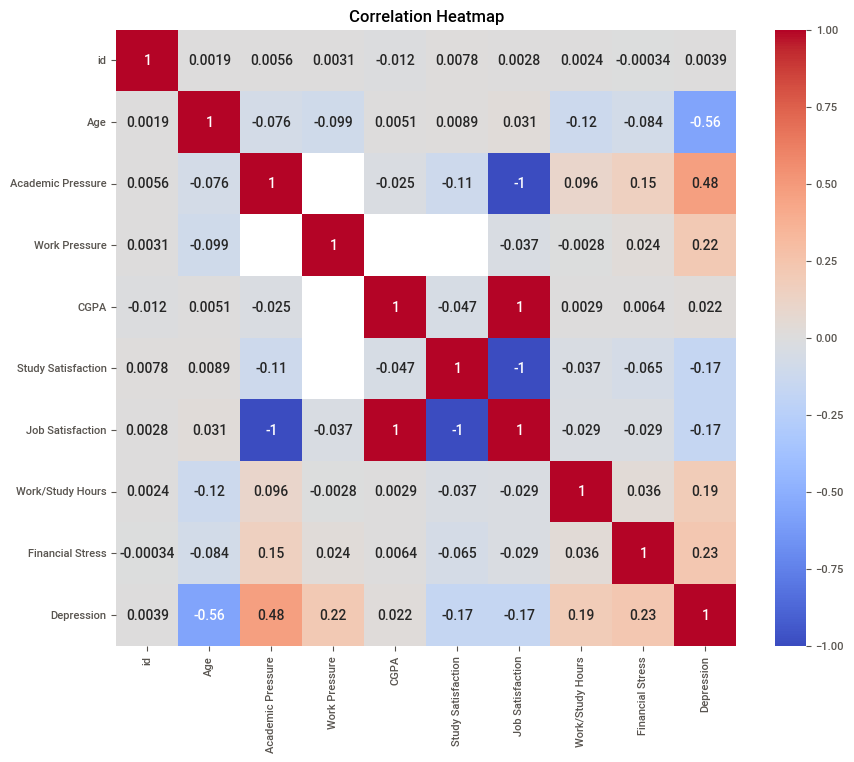

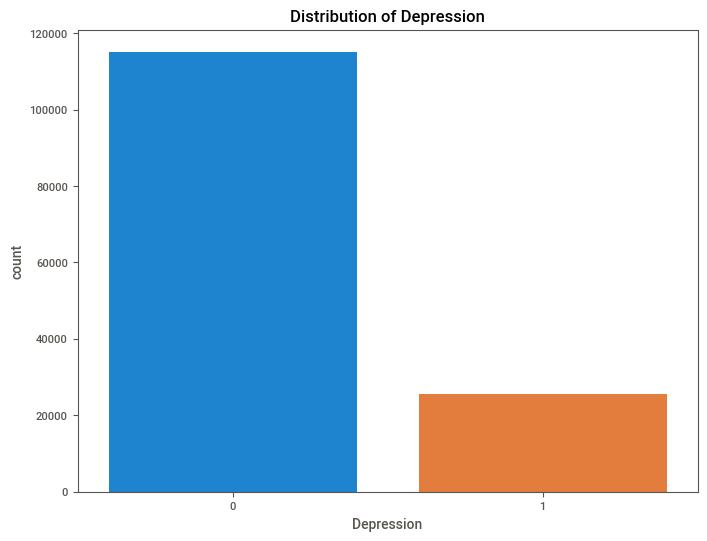

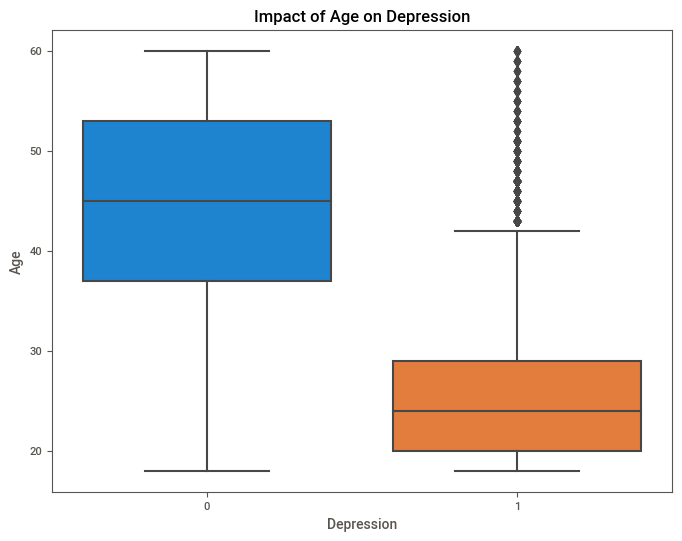

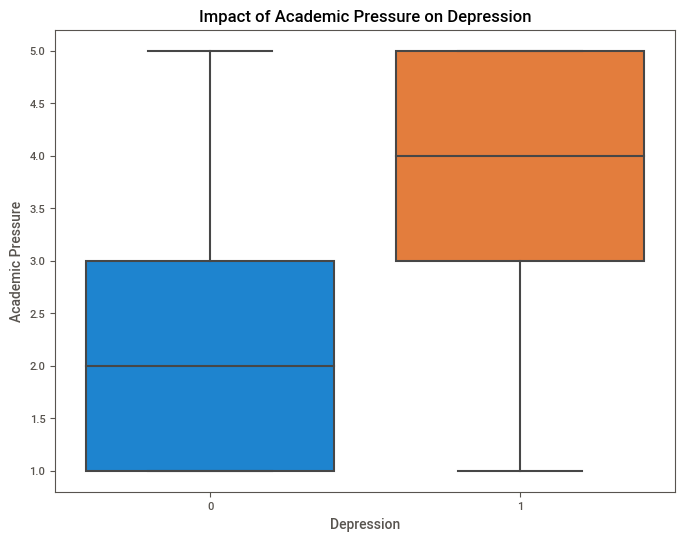

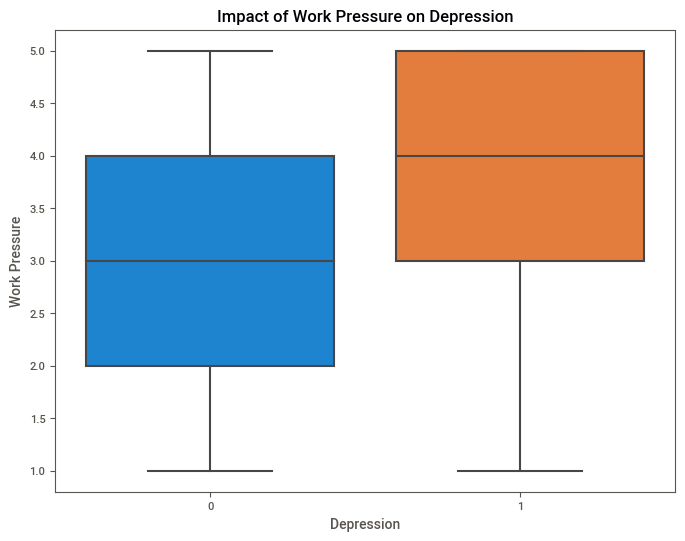

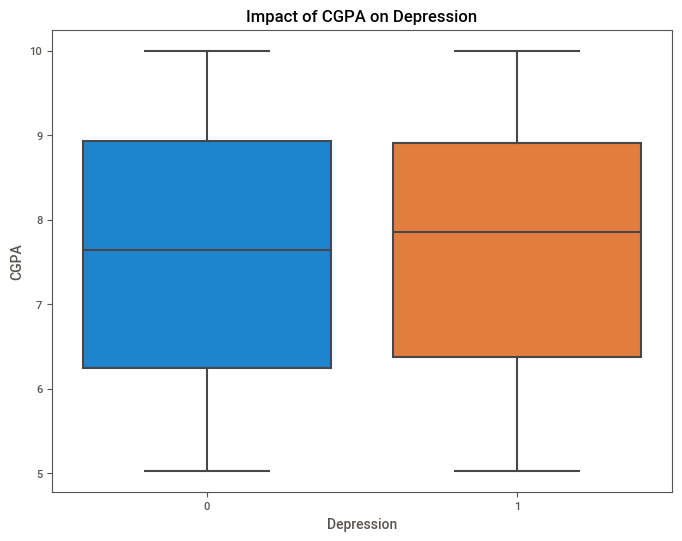

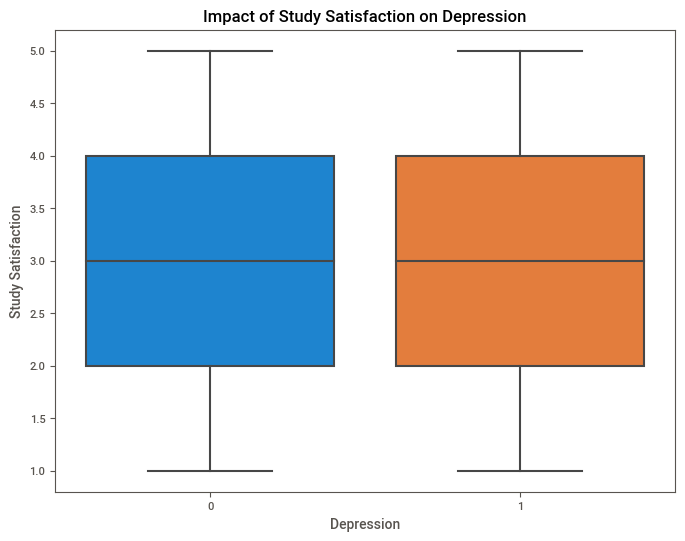

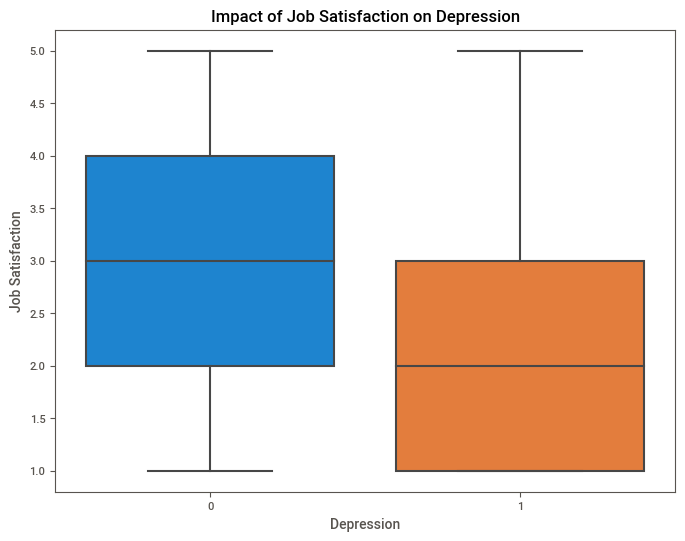

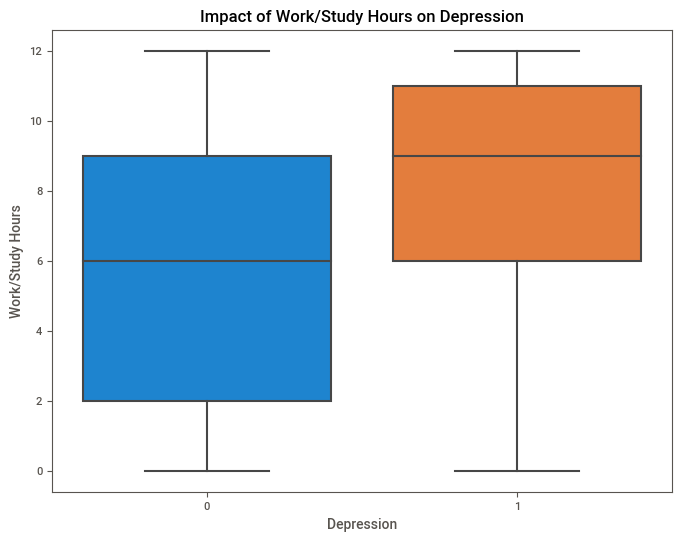

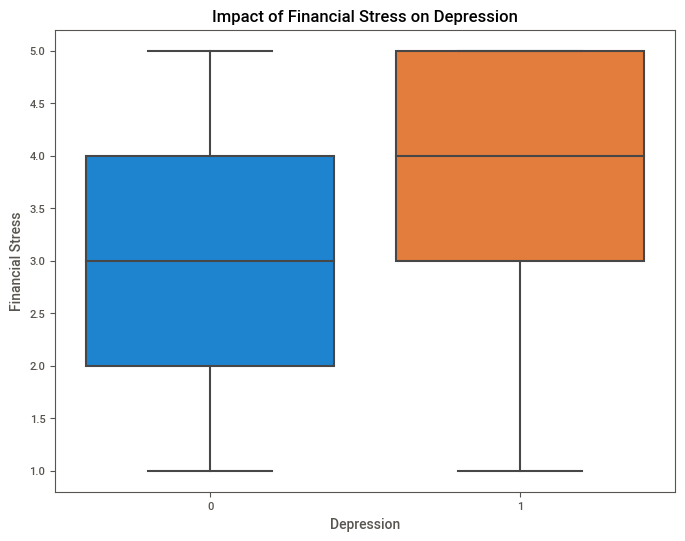

In [23]:
df = train_data.copy()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Plotting the distribution of Depression
plt.figure(figsize=(8, 6))
sns.countplot(x='Depression', data=df)
plt.title('Distribution of Depression')
plt.show()

# Plotting the impact of Age on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Age', data=df)
plt.title('Impact of Age on Depression')
plt.show()

# Plotting the impact of Academic Pressure on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Academic Pressure', data=df)
plt.title('Impact of Academic Pressure on Depression')
plt.show()

# Plotting the impact of Work Pressure on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Work Pressure', data=df)
plt.title('Impact of Work Pressure on Depression')
plt.show()

# Plotting the impact of CGPA on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='CGPA', data=df)
plt.title('Impact of CGPA on Depression')
plt.show()

# Plotting the impact of Study Satisfaction on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Study Satisfaction', data=df)
plt.title('Impact of Study Satisfaction on Depression')
plt.show()

# Plotting the impact of Job Satisfaction on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Job Satisfaction', data=df)
plt.title('Impact of Job Satisfaction on Depression')
plt.show()

# Plotting the impact of Work/Study Hours on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Work/Study Hours', data=df)
plt.title('Impact of Work/Study Hours on Depression')
plt.show()

# Plotting the impact of Financial Stress on Depression
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depression', y='Financial Stress', data=df)
plt.title('Impact of Financial Stress on Depression')
plt.show()

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Feature engineering</div>

In [24]:
# Generate EDA summary and format it as a JSON string
summary = eda_summary(train_data)
summary_json = json.dumps(summary, indent=4, default=str)  # summary_json is now a single string

# Prepare the first few rows of train and test data as strings
train_data_head = train_data.head().to_string(index=False)
test_data_head = test_data.head().to_string(index=False)

# Define the prompt template with placeholders for dynamic values
template_features = """The aim of this exploratory data analysis (EDA) is to understand the impact of various variables on depression. Below is the EDA summary:
{context}

Please generate Python code for feature engineering to enhance the model’s performance based on the provided EDA summary.
When handling missing values, take into consideration how much of the data is missing for each column and adapt the code based on this.
The datasets are preloaded in memory as `train_data` and `test_data`.
The feature engineering needs to be applied to both datasets in a way that avoids data leakage.
Be mindful of the fact that the data distribution in the train anb test data could be different and some categorical values present in the test data
could be abscent in the train data. The code will need to that into consideration.

The final transformed datasets should be called: train_data_processed and test_data_processed.

First rows of the train data:
{train_data_head}

First rows of the test data:
{test_data_head}
"""

# Create the ChatPromptTemplate
prompt = ChatPromptTemplate.from_template(template_features)

# Define the LLM model and output parser
output_parser = StrOutputParser()

# Chain components together
chain = prompt | model | output_parser

# Prepare the input as a dictionary with `context`, `train_data_head`, and `test_data_head`
input_data = {
    "context": summary_json,
    "train_data_head": train_data_head,
    "test_data_head": test_data_head
}

# Format the prompt with the input data for troubleshooting
formatted_prompt = prompt.format(
    context=summary_json,
    train_data_head=train_data_head,
    test_data_head=test_data_head
)

# Print the formatted prompt for troubleshooting
#print("Formatted Prompt for Troubleshooting:\n")
#print(formatted_prompt)

# Now proceed with invoking the chain
result = chain.invoke(input_data)

# Display the result as Markdown
display(Markdown(result))

Certainly! Below is a Python script that performs feature engineering based on the provided Exploratory Data Analysis (EDA) summary. The script handles missing values appropriately, encodes categorical variables, and ensures that transformations are applied consistently to both the training and testing datasets without causing data leakage.

### **Key Steps in the Feature Engineering Process:**

1. **Import Necessary Libraries:**
   - Utilize `pandas` for data manipulation.
   - Use `numpy` for numerical operations.
   - Leverage `sklearn` for preprocessing, including imputation, encoding, and pipeline creation.

2. **Identify Columns:**
   - **Drop Columns:** 
     - `id` and `Name` are identifier columns that likely don't contribute to the prediction of depression.
     - Numerical columns with more than 80% missing values (`Academic Pressure`, `CGPA`, `Study Satisfaction`).
   - **Numerical Columns:** Remaining numerical features after dropping.
   - **Categorical Columns:** All object-type columns except those being dropped.

3. **Handle Missing Values:**
   - **Numerical Features:**
     - Impute missing values with the median to handle skewed distributions effectively.
   - **Categorical Features:**
     - Impute missing values by adding a new category `"Missing"` to indicate missingness explicitly, which can sometimes carry useful information.

4. **Encoding Categorical Variables:**
   - Utilize `OneHotEncoder` with `handle_unknown='ignore'` to manage categories present in the test set but absent in the training set without causing errors.

5. **Create Preprocessing Pipelines:**
   - **Numerical Pipeline:** Impute missing values and optionally scale the data (scaling is omitted here but can be added if necessary).
   - **Categorical Pipeline:** Impute missing values and apply one-hot encoding.

6. **Apply Transformations:**
   - Fit the preprocessing pipeline on the training data.
   - Transform both the training and testing datasets using the fitted pipeline to ensure consistency and prevent data leakage.

7. **Final Output:**
   - The transformed datasets are stored in `train_data_processed` and `test_data_processed`.

### **Complete Python Code:**

```python
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Assuming train_data and test_data are already loaded as pandas DataFrames

# Step 1: Drop 'id' and 'Name' columns as they are identifiers
columns_to_drop = ['id', 'Name']
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

# Step 2: Drop numerical columns with >80% missing values
# From EDA: 'Academic Pressure', 'CGPA', 'Study Satisfaction' have ~80% missing
numerical_columns_to_drop = ['Academic Pressure', 'CGPA', 'Study Satisfaction']
train_data = train_data.drop(columns=numerical_columns_to_drop)
test_data = test_data.drop(columns=numerical_columns_to_drop)

# Step 3: Define remaining numerical and categorical columns
# From data_types after dropping:
# Numerical: 'Age', 'Work Pressure', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression'
numerical_features = ['Age', 'Work Pressure', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

# Categorical: 'Gender', 'City', 'Working Professional or Student', 'Profession',
# 'Sleep Duration', 'Dietary Habits', 'Degree',
# 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'
categorical_features = [
    'Gender', 'City', 'Working Professional or Student', 'Profession',
    'Sleep Duration', 'Dietary Habits', 'Degree',
    'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'
]

# Step 4: Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    # Optionally, add scaling here if needed
    # ('scaler', StandardScaler())
])

# For numerical columns with little to no missing (like Financial Stress with 0.3% missing),
# median imputation is still safe.

# Step 5: Define preprocessing for categorical data
# For columns with missing values:
# 'Profession' has 26% missing, treat missing as a separate category
# 'Dietary Habits', 'Degree', 'Financial Stress' have very few missing
# Others have no missing

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Step 6: Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Step 7: Separate target variable from training data
X_train = train_data.drop('Depression', axis=1)
y_train = train_data['Depression']

X_test = test_data.copy()  # Assuming 'Depression' is not in test_data

# Step 8: Fit the preprocessor on training data and transform both train and test
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Step 9: Convert the processed arrays back to DataFrames
# Get feature names after one-hot encoding
# For numerical features, names are the same
# For categorical, get names from OneHotEncoder

# Extract feature names
num_features = numerical_features
# Get onehot feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)

# Combine all feature names
processed_feature_names = list(num_features) + list(cat_features)

# Create DataFrames
train_data_processed = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train.index)
train_data_processed['Depression'] = y_train

test_data_processed = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)

# Optional: Reset index if necessary
train_data_processed.reset_index(drop=True, inplace=True)
test_data_processed.reset_index(drop=True, inplace=True)

# Display the first few rows of the processed data (optional)
print("Processed Training Data:")
print(train_data_processed.head())

print("\nProcessed Testing Data:")
print(test_data_processed.head())
```

### **Explanation of the Code:**

1. **Dropping Unnecessary Columns:**
   - The `id` and `Name` columns are dropped as they are unlikely to be useful for modeling depression.
   - Numerical columns with more than 80% missing values (`Academic Pressure`, `CGPA`, `Study Satisfaction`) are also dropped to maintain data quality.

2. **Identifying Feature Types:**
   - **Numerical Features:** Identified based on the `data_types` and excluding the dropped columns.
   - **Categorical Features:** All remaining object-type columns except those that were dropped.

3. **Preprocessing Pipelines:**
   - **Numerical Transformer:** Imputes missing values in numerical features using the median. Median is chosen as it is robust to outliers.
   - **Categorical Transformer:** Imputes missing values by introducing a new category `"Missing"`, which allows the model to potentially learn patterns associated with missingness. It then applies one-hot encoding while ignoring unknown categories in the test set.

4. **Combining Transformers:**
   - The `ColumnTransformer` applies the numerical and categorical transformers to their respective columns.

5. **Fitting and Transforming the Data:**
   - The preprocessing pipeline is fitted on the training data (`X_train`) to learn the imputation values and encoding mappings.
   - Both the training (`X_train`) and testing (`X_test`) data are transformed using the fitted pipeline to ensure consistency.

6. **Reconstructing DataFrames:**
   - The transformed numerical and categorical features are combined into a single DataFrame for both training and testing datasets.
   - The target variable `Depression` is appended to the processed training data.

7. **Final Output:**
   - `train_data_processed` contains the transformed training features along with the target variable.
   - `test_data_processed` contains the transformed testing features ready for model prediction.

### **Notes:**

- **Handling Imbalances:** Given that `Depression` is the target variable, you might want to check for class imbalance and consider techniques like oversampling, undersampling, or using appropriate evaluation metrics.
  
- **Scaling Numerical Features:** While not included in this script, scaling numerical features (e.g., using `StandardScaler` or `MinMaxScaler`) can be beneficial, especially for models sensitive to feature scales.

- **Feature Selection:** Post feature engineering, consider performing feature selection to identify the most impactful features for predicting depression.

- **Model Training:** With the processed datasets ready, you can proceed to split `train_data_processed` into training and validation sets and train your machine learning models accordingly.

I hope this helps you effectively prepare your data for modeling! If you have any further questions or need additional assistance, feel free to ask.

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Assuming train_data and test_data are preloaded in memory

# Function to handle missing values
def handle_missing_values(df):
    # Drop columns with more than 50% missing values
    df = df.drop(columns=['Academic Pressure', 'CGPA', 'Study Satisfaction'])
    
    # Impute missing values for numerical columns with median
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])
    
    # Impute missing values for categorical columns with the most frequent value
    cat_cols = df.select_dtypes(include=['object']).columns
    imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer.fit_transform(df[cat_cols])
    
    return df

# Function to encode categorical variables
def encode_categorical_variables(train_df, test_df):
    # Label Encoding for binary categorical variables
    binary_cols = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
    le = LabelEncoder()
    for col in binary_cols:
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
    
    # One-Hot Encoding for other categorical variables
    cat_cols = ['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
    train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
    test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)
    
    # Align the test set with the train set
    train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)
    
    return train_df, test_df

# Handle missing values
train_data = handle_missing_values(train_data)
test_data = handle_missing_values(test_data)

# Encode categorical variables
train_data, test_data = encode_categorical_variables(train_data, test_data)

# Ensure the target variable is at the end
train_data_processed = train_data[[col for col in train_data.columns if col != 'Depression'] + ['Depression']]
test_data_processed = test_data

In [26]:
# Display the first few rows of the processed datasets
train_data_processed.head()

,id,Name,Gender,Age,Working Professional or Student,Work Pressure,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,...,Degree_S.Arch,Degree_S.Pharm,Degree_S.Tech,Degree_UX/UI Designer,Degree_Unite,Degree_Veda,Degree_Vivaan,Degree_Vrinda,Degree_Working Professional,Depression
0,0.0,Aaradhya,0,49.0,1,5.0,2.0,0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
1,1.0,Vivan,1,26.0,1,4.0,3.0,1,7.0,3.0,...,0,0,0,0,0,0,0,0,0,1.0
2,2.0,Yuvraj,1,33.0,0,3.0,3.0,1,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
3,3.0,Yuvraj,1,22.0,1,5.0,1.0,1,10.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
4,4.0,Rhea,0,30.0,1,1.0,1.0,1,9.0,4.0,...,0,0,0,0,0,0,0,0,0,0.0


In [27]:
train_data_processed.shape

(140700, 343)

In [28]:
train_data_processed.columns.tolist()

['id',
 'Name',
 'Gender',
 'Age',
 'Working Professional or Student',
 'Work Pressure',
 'Job Satisfaction',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'City_Aaradhya',
 'City_Aditya',
 'City_Agra',
 'City_Ahmedabad',
 'City_Aishwarya',
 'City_Anvi',
 'City_Armaan',
 'City_Atharv',
 'City_Ayansh',
 'City_Ayush',
 'City_Bangalore',
 'City_Bhavna',
 'City_Bhopal',
 'City_Chennai',
 'City_Chhavi',
 'City_City',
 'City_Delhi',
 'City_Dhruv',
 'City_Faridabad',
 'City_Galesabad',
 'City_Gaurav',
 'City_Ghaziabad',
 'City_Gurgaon',
 'City_Harsh',
 'City_Harsha',
 'City_Hyderabad',
 'City_Indore',
 'City_Ishanabad',
 'City_Ishkarsh',
 'City_Ithal',
 'City_Itheg',
 'City_Ivaan',
 'City_Jaipur',
 'City_Jhanvi',
 'City_Kagan',
 'City_Kalyan',
 'City_Kanpur',
 'City_Kashish',
 'City_Kashk',
 'City_Keshav',
 'City_Khaziabad',
 'City_Khushi',
 'City_Kibara',
 'City_Kolkata',
 'City_Krinda',
 'City_Krishna',
 'City_Less 

In [29]:
test_data_processed.head()

,id,Name,Gender,Age,Working Professional or Student,Work Pressure,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,...,Degree_Ritik,Degree_S.Arch,Degree_S.Pharm,Degree_S.Tech,Degree_UX/UI Designer,Degree_Unite,Degree_Veda,Degree_Vivaan,Degree_Vrinda,Degree_Working Professional
0,140700.0,Shivam,1,53.0,1,2.0,5.0,0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,140701.0,Sanya,0,58.0,1,2.0,4.0,0,6.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,140702.0,Yash,1,53.0,1,4.0,1.0,1,12.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,140703.0,Nalini,0,23.0,0,3.0,3.0,1,10.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,140704.0,Shaurya,1,47.0,1,5.0,5.0,1,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_data_processed.shape

(93800, 343)

In [31]:
test_data_processed.columns.tolist()

['id',
 'Name',
 'Gender',
 'Age',
 'Working Professional or Student',
 'Work Pressure',
 'Job Satisfaction',
 'Have you ever had suicidal thoughts ?',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression',
 'City_Aaradhya',
 'City_Aditya',
 'City_Agra',
 'City_Ahmedabad',
 'City_Aishwarya',
 'City_Anvi',
 'City_Armaan',
 'City_Atharv',
 'City_Ayansh',
 'City_Ayush',
 'City_Bangalore',
 'City_Bhavna',
 'City_Bhopal',
 'City_Chennai',
 'City_Chhavi',
 'City_City',
 'City_Delhi',
 'City_Dhruv',
 'City_Faridabad',
 'City_Galesabad',
 'City_Gaurav',
 'City_Ghaziabad',
 'City_Gurgaon',
 'City_Harsh',
 'City_Harsha',
 'City_Hyderabad',
 'City_Indore',
 'City_Ishanabad',
 'City_Ishkarsh',
 'City_Ithal',
 'City_Itheg',
 'City_Ivaan',
 'City_Jaipur',
 'City_Jhanvi',
 'City_Kagan',
 'City_Kalyan',
 'City_Kanpur',
 'City_Kashish',
 'City_Kashk',
 'City_Keshav',
 'City_Khaziabad',
 'City_Khushi',
 'City_Kibara',
 'City_Kolkata',
 'City_Krinda',
 'City_Krishna

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Create a baseline model with AutoGluon - with Feature engineering</div>

In [32]:
# Preparing training data
# Drop 'id' column since it is not useful for training
train_data_processed = train_data_processed.drop(columns=['id'])

In [33]:
# Train AutoGluon model

# Specify the target column and set it to 'depression' for binary classification
target = 'Depression'

# Create a temporary directory to avoid saving models to a permanent folder
temp_model_path = tempfile.mkdtemp()

# Train AutoGluon model with the desired adjustments
predictor = TabularPredictor(label=target, eval_metric='f1', path=temp_model_path).fit(
    train_data_processed,
    presets='best_quality',  # Using the best quality preset for higher accuracy
    time_limit=TIME_LIMIT,  # Control the training time (in seconds)
    num_bag_folds=10,  # Enable ensembling by using bagging with 5 folds
    num_stack_levels=2,  # Enable stacking to further improve model performance
    ag_args_fit={'use_gpu': False},  # Set to True if using GPU for model training
    verbosity=0  # Suppress logging output (0: most silent, 4: most detailed)
)

2024-12-07 22:13:44,742	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-07 22:13:47,396	INFO worker.py:1752 -- Started a local Ray instance.
2024-12-07 23:13:21,090	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-07 23:13:21,094	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-07 23:13:21,098	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


In [34]:
# Review the leaderboard of different models trained by AutoGluon

leaderboard = predictor.leaderboard(silent=True)
leaderboard.to_csv('leaderboard_1.csv', index=False)
leaderboard.head(10)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.814758,f1,17.920264,2214.761821,0.055809,21.495184,2,True,16
1,XGBoost_BAG_L1,0.811745,f1,2.446156,304.403013,2.446156,304.403013,1,True,11
2,CatBoost_BAG_L1,0.811109,f1,0.606241,541.686461,0.606241,541.686461,1,True,7
3,NeuralNetTorch_BAG_L1,0.810605,f1,1.250978,368.062090,1.250978,368.062090,1,True,12
4,CatBoost_r177_BAG_L1,0.810491,f1,0.525892,197.742443,0.525892,197.742443,1,True,14
5,NeuralNetFastAI_BAG_L1,0.808815,f1,4.005235,694.993654,4.005235,694.993654,1,True,10
6,LightGBM_BAG_L1,0.808112,f1,5.392551,62.440412,5.392551,62.440412,1,True,4
7,LightGBMXT_BAG_L1,0.807968,f1,9.029952,86.378976,9.029952,86.378976,1,True,3
8,LightGBMLarge_BAG_L1,0.807632,f1,7.880420,93.091999,7.880420,93.091999,1,True,13
9,RandomForestEntr_BAG_L1,0.795033,f1,12.216956,41.327052,12.216956,41.327052,1,True,6


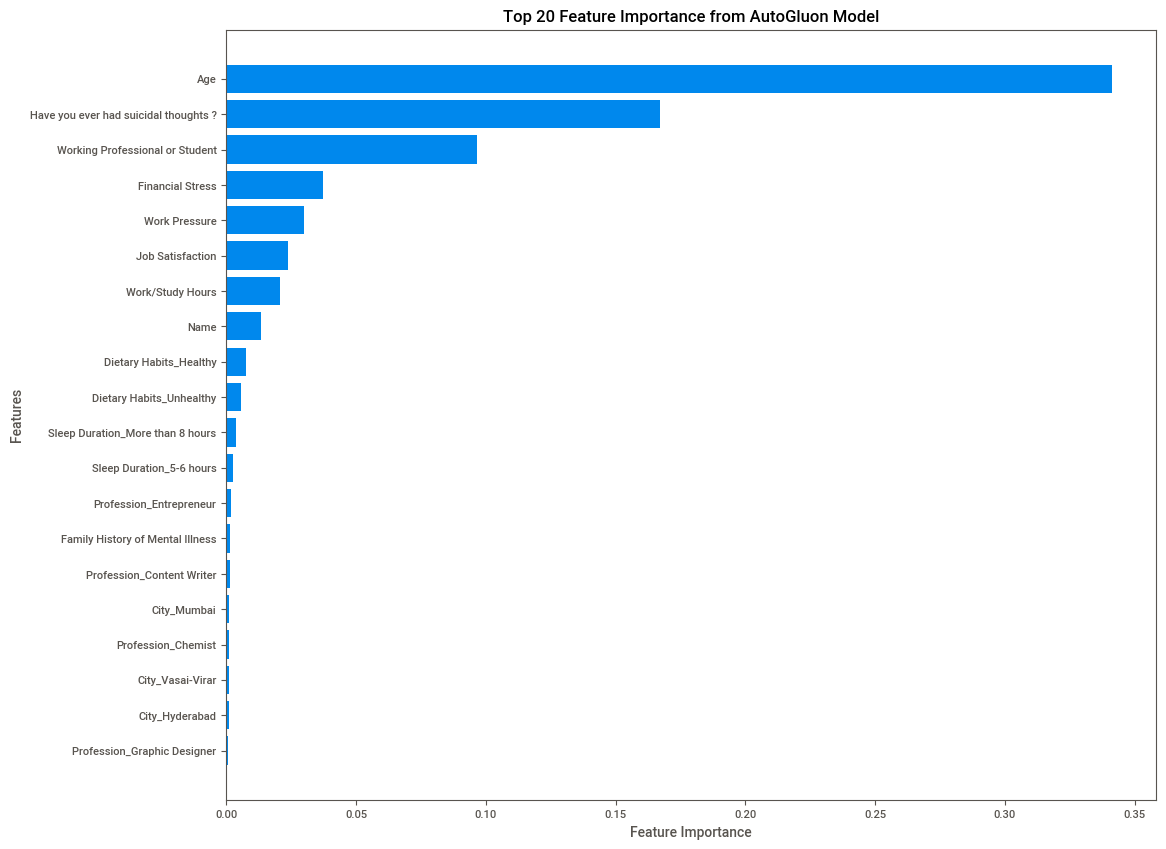

In [35]:
feature_importance = predictor.feature_importance(train_data_processed)
top_features = feature_importance.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(12, 10))
plt.barh(top_features.index, top_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance from AutoGluon Model')
plt.gca().invert_yaxis()
plt.show()

In [36]:
# Prepare submission

# Drop the 'id' column before making predictions
test_data_processed = test_data_processed.drop(columns=['id'])

# Use AutoGluon to predict class labels (0 or 1) for 'depression'
y_test_pred = predictor.predict(test_data_processed)

# Create the submission file
sub1 = pd.DataFrame({
    'id': test_data['id'],
    'Depression': y_test_pred
})

# Save the submission file
sub1.to_csv('depression_prediction_feature_engineering_autogluon_sub.csv', index=False)

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Create a baseline model with AutoGluon - no Feature engineering</div>

In [37]:
# Preparing training data
# Drop 'id' column since it is not useful for training
train_data = train_data.drop(columns=['id'])

In [38]:
# Train AutoGluon model

# Specify the target column and set it to 'depression' for binary classification
target = 'Depression'

# Create a temporary directory to avoid saving models to a permanent folder
temp_model_path = tempfile.mkdtemp()

# Train AutoGluon model with the desired adjustments
predictor = TabularPredictor(label=target, eval_metric='f1', path=temp_model_path).fit(
    train_data,
    presets='best_quality',  # Using the best quality preset for higher accuracy
    time_limit=TIME_LIMIT,  # Control the training time (in seconds)
    num_bag_folds=10,  # Enable ensembling by using bagging with 5 folds
    num_stack_levels=2,  # Enable stacking to further improve model performance
    ag_args_fit={'use_gpu': False},  # Set to True if using GPU for model training
    verbosity=0  # Suppress logging output (0: most silent, 4: most detailed)
)

2024-12-08 00:28:54,652	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-12-08 00:28:54,655	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_ray_fit() (pid=14074, ip=172.19.2.2)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 413, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold, time_limit=time_limit_fold, **resources, **kwargs_fold)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 925, in fit
    out = self._fit(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/autogluon/tabular/models/tabular_nn/torch/tabular_nn_torch.py", line 224, in _fit
    raise TimeLimitExceeded
autogluon.core.utils.exceptions.TimeLimitExceeded
2024-

In [39]:
# Review the leaderboard of different models trained by AutoGluon

leaderboard = predictor.leaderboard(silent=True)
leaderboard.to_csv('leaderboard_2.csv', index=False)
leaderboard.head(10)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.815100,f1,101.996353,1654.105994,0.054632,12.666433,3,True,22
1,WeightedEnsemble_L4,0.815100,f1,101.997719,1676.737084,0.055998,35.297524,4,True,29
2,NeuralNetFastAI_BAG_L2,0.814031,f1,77.457419,1319.804400,4.875022,230.648664,2,True,20
3,WeightedEnsemble_L2,0.814018,f1,4.549584,727.619318,0.057738,14.986613,2,True,12
4,CatBoost_BAG_L2,0.813615,f1,73.002405,1295.221877,0.420008,206.066141,2,True,17
5,XGBoost_BAG_L2,0.812739,f1,74.099183,1177.489056,1.516787,88.333320,2,True,21
6,CatBoost_BAG_L3,0.812629,f1,143.480834,2088.308332,0.393855,129.610470,3,True,27
7,LightGBMXT_BAG_L2,0.812264,f1,76.589539,1156.014926,4.007142,66.859190,2,True,13
8,LightGBMXT_BAG_L3,0.811631,f1,146.459036,2023.284010,3.372057,64.586148,3,True,23
9,RandomForestEntr_BAG_L2,0.811502,f1,84.414328,1147.022916,11.831931,57.867180,2,True,16


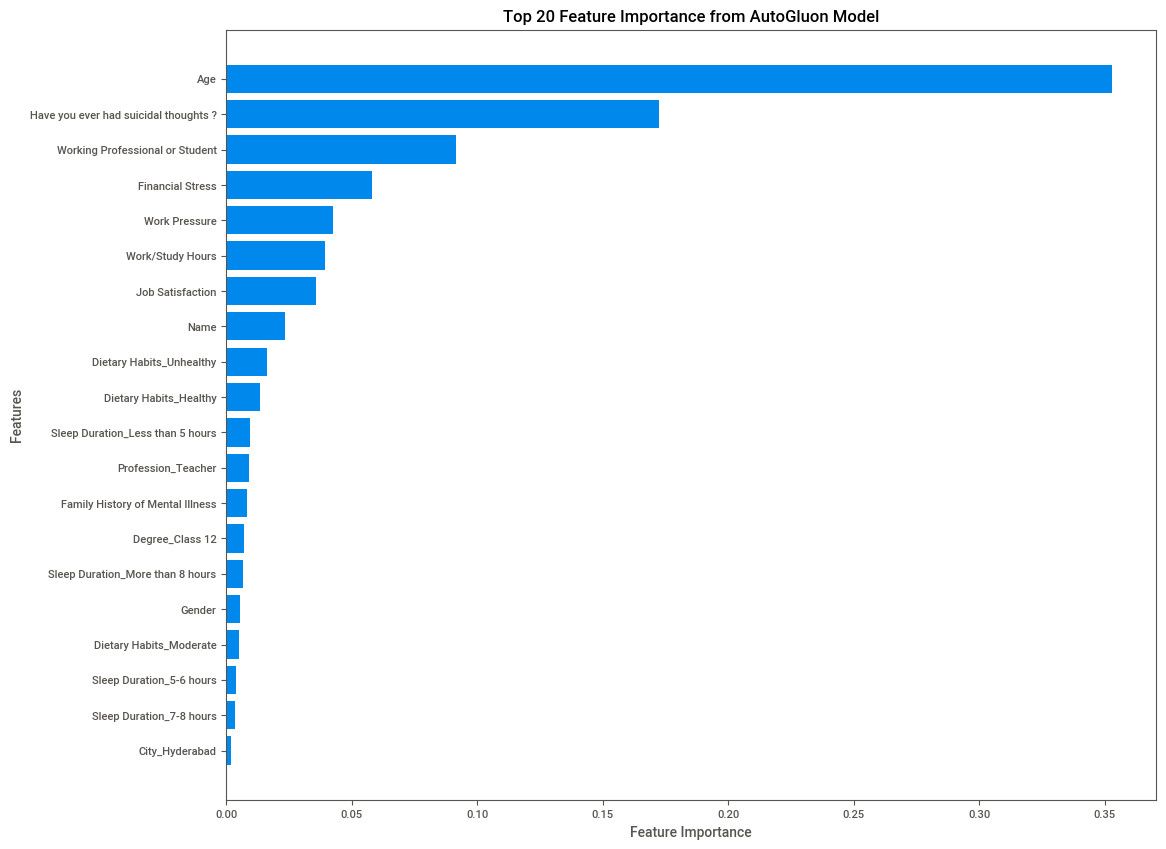

In [40]:
feature_importance = predictor.feature_importance(train_data_processed)
top_features = feature_importance.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(12, 10))
plt.barh(top_features.index, top_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importance from AutoGluon Model')
plt.gca().invert_yaxis()
plt.show()

In [41]:
# Prepare submission

# Drop the 'id' column before making predictions
test_data_processed = test_data.drop(columns=['id'])

# Use AutoGluon to predict class labels (0 or 1) for 'depression'
y_test_pred = predictor.predict(test_data_processed)

# Create the submission file
sub2 = pd.DataFrame({
    'id': test_data['id'],
    'Depression': y_test_pred
})

# Save the submission file
sub2.to_csv('depression_prediction_autogluon_sub.csv', index=False)

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Final Ensemble</div>

## Submission Generation

This notebook generates two submissions for scoring:

- `depression_prediction_autogluon_sub.csv`
- `final_ensemble.csv`

## Final Ensemble Submission

For the final ensemble submission, I combine the predictions from this notebook with results from four public notebooks, each utilizing different methods. Importantly, these public notebooks do not contain ensemble predictions from other sources. While the ensemble submission scores higher on the public leaderboard, it carries a greater risk of overfitting, particularly because this competition is based on accuracy metrics.

## Best Ensembling Approach

The most effective ensembling approach involves combining out-of-fold predictions from models trained using cross-validation with a unified cross-validation scoring strategy. A simple meta-model, such as logistic regression or a voting method, can then be applied to enhance performance.

## Example of Ensembling notebooks I like using stacking and voting:
- [LGB-XGB-CatB line Blending with CatB](https://www.kaggle.com/code/rudenkobogdan/ps4e11-lgb-xgb-catb-line-blending-with-catb)
- [EDA - Optuna - Features - Ensemble](https://www.kaggle.com/code/wguesdon/ps-s4-e10-eda-optuna-features-ensemble)
- [Don't Overfit 💡 | 5-Fold CV Voting XGB/CatB/LGB](https://www.kaggle.com/code/mayukh18/don-t-overfit-5-fold-cv-voting-xgb-catb-lgb)
- [S04E11 | Depression Prediction | Ensemble](https://www.kaggle.com/code/ravaghi/s04e11-depression-prediction-ensemble)

## Notebooks used for the Ensemble Submission

- [This code fixed my depression](https://www.kaggle.com/code/adyiemaz/this-code-fixed-my-depression/notebook)
- [Mental health | Catboost | Edited](https://www.kaggle.com/code/abdmental01/mental-health-catboost-edited)
- [[0.94317] 🚀 Catboost + Optuna | New Top5 Features](https://www.kaggle.com/code/harshg97/0-94317-catboost-optuna-new-top5-features)
- [Mental health - automl baseline](https://www.kaggle.com/code/thomasmeiner/mental-health-automl-baseline)

In [42]:
sub3 = pd.read_csv('/kaggle/input/ps4e11-submissions-for-ensemble/catboost_optuna_new_top5_features.csv').sort_values(by='id').reset_index(drop=True)
sub4 = pd.read_csv('/kaggle/input/ps4e11-submissions-for-ensemble/mental_health_automl_baseline.csv').sort_values(by='id').reset_index(drop=True)
sub5 = pd.read_csv('/kaggle/input/ps4e11-submissions-for-ensemble/mental_health_catboost_edited.csv').sort_values(by='id').reset_index(drop=True)
sub6 = pd.read_csv('/kaggle/input/ps4e11-submissions-for-ensemble/this_code_fixed_my_depression.csv').sort_values(by='id').reset_index(drop=True)

In [43]:
sub1.head()

,id,Depression
0,140700.0,0.0
1,140701.0,0.0
2,140702.0,0.0
3,140703.0,1.0
4,140704.0,0.0


In [44]:
sub2.head()

,id,Depression
0,140700.0,0.0
1,140701.0,0.0
2,140702.0,0.0
3,140703.0,1.0
4,140704.0,0.0


In [45]:
sub3.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [46]:
sub4.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [47]:
sub5.head()

,id,Depression
0,140700,0.0
1,140701,0.0
2,140702,0.0
3,140703,1.0
4,140704,0.0


In [48]:
sub6.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [49]:
# List of submission dataframes
submissions = [sub1, sub2, sub3, sub4, sub5, sub6]

# Ensuring all values are integers
for sub in submissions:
    sub['Depression'] = sub['Depression'].astype(int)

# Creating a copy of the 'id' column from the first submission
ensemble = submissions[0][['id']].copy()

# Stack all predictions into a 2D numpy array and calculate the majority vote
predictions = np.array([sub['Depression'].values for sub in submissions])
ensemble['Depression'] = (np.sum(predictions, axis=0) >= len(submissions) / 2).astype(int)  # Majority vote logic

# Display the first few rows of the ensemble dataframe
display(ensemble.head())

# Saving the output to a CSV file
ensemble.to_csv('final_ensemble.csv', index=False)

,id,Depression
0,140700.0,0
1,140701.0,0
2,140702.0,0
3,140703.0,1
4,140704.0,0
